# Práctica series temporales

- Lucian Iacob

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
matplotlib.rc('figure', figsize=(15, 5))

from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.stattools import adfuller, kpss

from os.path import isfile

import warnings
warnings.filterwarnings("ignore")

output_folder='./Output'

## Carga de los datos y preproceso

In [2]:
eolica = pd.read_csv('eolica.csv',
                    header=0, parse_dates=[0], index_col=[0], usecols=[0, 3], dayfirst=True, 
                    squeeze=True)

Nos quedamos con la primera columna que es la fecha y con la cuarta que es la cantidad de energía producida. Ahora mostramos los primeros datos de la serie para comprobar que se han cargado bien.

In [3]:
eolica.head(10)

Date
2016-01-01    280606.59
2016-01-02    181981.12
2016-01-03    329470.87
2016-01-04    216707.38
2016-01-05    204859.99
2016-01-06    278101.80
2016-01-07    247007.30
2016-01-08          NaN
2016-01-09          NaN
2016-01-10          NaN
Name: WindEnergy, dtype: float64

Veamos también cuántos datos tenemos en nuestra serie temporal.

In [4]:
len(eolica)

1096

#### Missing values

Ya en la anterior celda hemos podido ver que hay valores que faltan, veamos cuántos son antes de pasar a rellenarlos.

In [5]:
eolica.isna().sum()

8

Aunque pocos, toca rellenar estos huecos. Para ello utilizaremos series.interpolate() de pandas con un método lineal. Antes de aplicarlo veamos las estadísticas de los datos para ver si la interpolación supone un cambio drástico (no debería al ser solo 8 valores).

In [6]:
eolica.describe()

count      1088.000000
mean      68592.571756
std       70408.721701
min           0.000000
25%       15139.600000
50%       43866.700000
75%      100261.447500
max      354637.160000
Name: WindEnergy, dtype: float64

In [7]:
eolica.interpolate(method='linear',axis=0).describe()

count      1096.000000
mean      68797.558476
std       70603.505364
min           0.000000
25%       15212.700000
50%       43866.700000
75%      100452.795000
max      354637.160000
Name: WindEnergy, dtype: float64

El cambio ha subido un poco la media pero nada más, podemos asumir que este método de rellenar es suficiente.

El cambio anterior no ha sido aplicado. Toca definir una nueva serie a partir de la original o usar el parámetro inplace con valor True para que tenga efecto.

In [8]:
eolica.interpolate(method='linear',axis=0, inplace=True)
eolica.isna().sum()

0

#### Transformación a porcentaje de potencia

In [9]:
eolica_porcentual = eolica/17560/24

In [10]:
eolica_porcentual

Date
2016-01-01    0.665828
2016-01-02    0.431808
2016-01-03    0.781774
2016-01-04    0.514207
2016-01-05    0.486095
                ...   
2018-12-27    0.025798
2018-12-28    0.042895
2018-12-29    0.203719
2018-12-30    0.151651
2018-12-31    0.075124
Name: WindEnergy, Length: 1096, dtype: float64

#### Valores nulos

In [11]:
sum(eolica_porcentual == 0)

4

In [12]:
eolica_porcentual[eolica_porcentual == 0]

Date
2018-08-17    0.0
2018-08-18    0.0
2018-08-19    0.0
2018-08-20    0.0
Name: WindEnergy, dtype: float64

Tenemos solo 4 días de agosto de 2018 en los que los valores de viento son nulos. Ante tan pocos valores nulos no podemos descartar que la serie pueda ser regida por un modelo multiplicativo. Lo comprobaremos más adelante.

## Análisis

### Visualización

<AxesSubplot:xlabel='Date'>

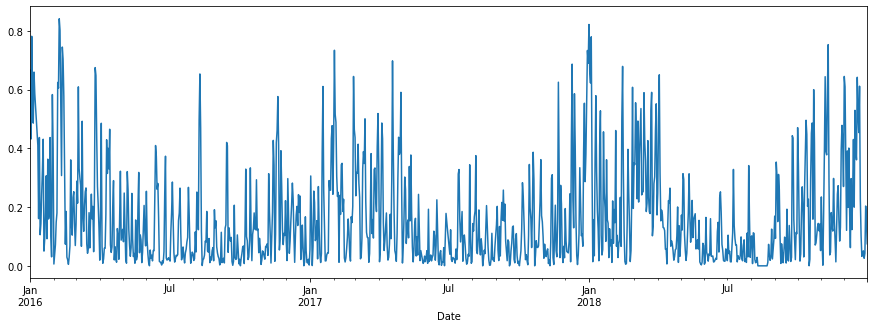

In [13]:
plt.figure();eolica_porcentual.plot()

A primera vista, dentro del "caos" de datos parece que a nivel anual tenemos cierta repetición en que los primeros meses del año tenemos valores elevados y a mitad de año tenemos valores valle, volviendo a ascender conforme acaba el año. Habrá que verlo más en detalle adelante con diferentes tests.

#### Anual

<AxesSubplot:xlabel='Date'>

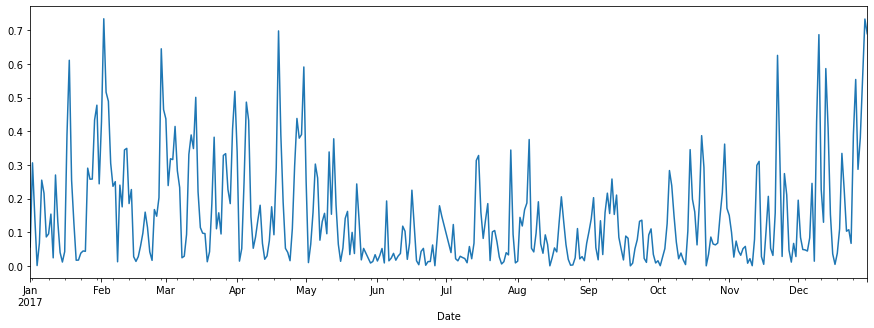

In [14]:
plt.figure();eolica_porcentual['2017'].plot()

#### Mensual

Pasemos a nivel mensual a ver si podemos apreciar algo.

<AxesSubplot:xlabel='Date'>

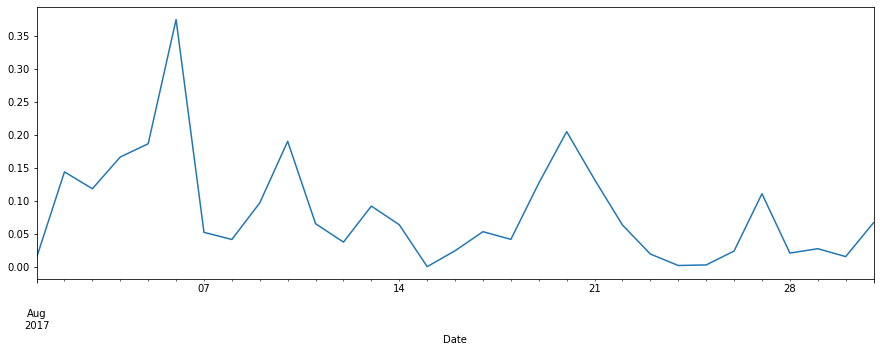

In [15]:
plt.figure();eolica_porcentual['2017-08'].plot()

<AxesSubplot:xlabel='Date'>

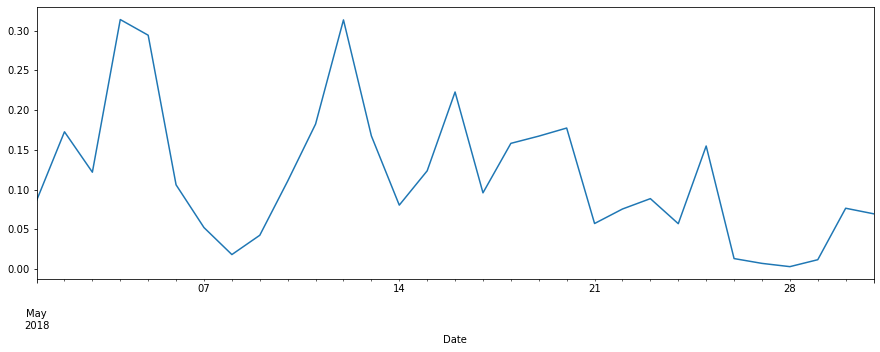

In [16]:
plt.figure();eolica_porcentual['2018-05'].plot()

Parece que a nivel anual tenemos esa tendencia que hemos mencionado, pero a nivel mensual no se aprecia nada. Pasemos a otros análisis.

### Tendencia y estacionalidad

#### Test ADF

Recordemos las hipótesis del test ADF:
* *Hipótesis nula*: La ST es no estacionaria.
* *Hipótesis alternativa*: La serie es estacionaria.

In [17]:
dftest = adfuller(eolica_porcentual)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                         'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                   -4.142392
p-value                           0.000824
#Lags Used                       20.000000
Number of Observations Used    1075.000000
Critical Value (1%)              -3.436448
Critical Value (5%)              -2.864232
Critical Value (10%)             -2.568204
dtype: float64


El test ADF nos lleva a rechazar la hipótesis nula al tener un p-value < 0.05 y un estadísitico más pequeño que el valor crítico del 1% incluso. Esto nos dice que la serie es estacionaria.

#### Test KPSS

Recordemos las hipótesis del test KPSS:
* *Hipótesis nula*: La ST es estacionaria, pero con tendencia.
* *Hipótesis alternativa*: La serie es no estacionaria.

In [18]:
kpsstest = kpss(eolica_porcentual, nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic            0.191381
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


El test KPSS nos lleva a aceptar la hipótesis nula al tener p-value > 0.05 y un estadístico menor que los críticos. Esto nos dice que la serie es estacionaria con tendencia.

Ambos tests nos dicen que la serie es estacionaria ( ***Rechazo*** $H_0$ en ADF y ***Acepto*** $H_1$ en KPSS). Pasemos a la descomposición estacional para comprobarlo.

#### Descomposición estacional

Puesto que la amplitud de la serie no parece variar exponencialmente probemos a usar una descomposición aditiva a ver cómo se ve la serie:

Añadiendo un periodo de unos 7 puntos, es decir, una semana al tener solo una medida al día.

<Figure size 1080x360 with 0 Axes>

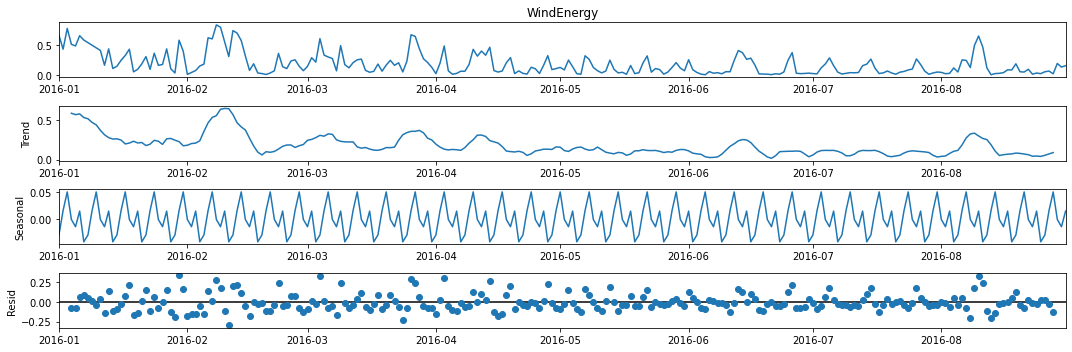

In [19]:
eolica_copy = eolica_porcentual['2016-01':'2016-8'].copy()
result=tsa.seasonal_decompose(eolica_copy, model='additive', period=7)
plt.figure();result.plot();

Vemos que una componente estacional muy pequeña que prácticamente podemos despreciar, lo que nos confirma aún más que la serie es estacionaria.

Cabe destacar que se usar un mes y nos saldría una componente periódica pero es porque un mes es múltiplo de una semana. Nos quedamos con el periodo de tiempo más pequeño.

#### ACF y PACF

Pasamos ahora a las autocorrelaciones. Si la serie es estacionaria, debería decrecer de forma rápida a partir de unos cuantos ```lags```.

<Figure size 1080x360 with 0 Axes>

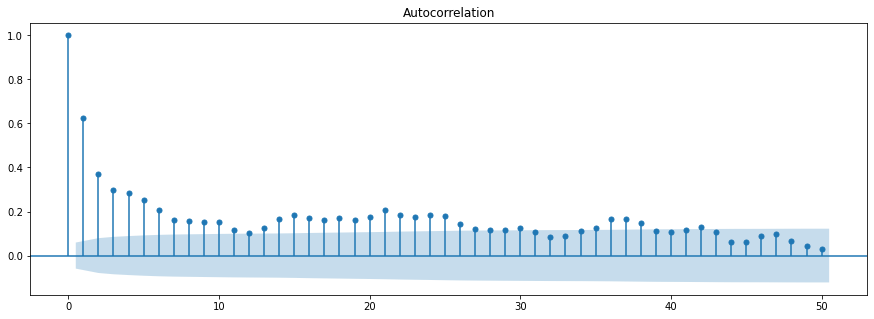

<Figure size 1080x360 with 0 Axes>

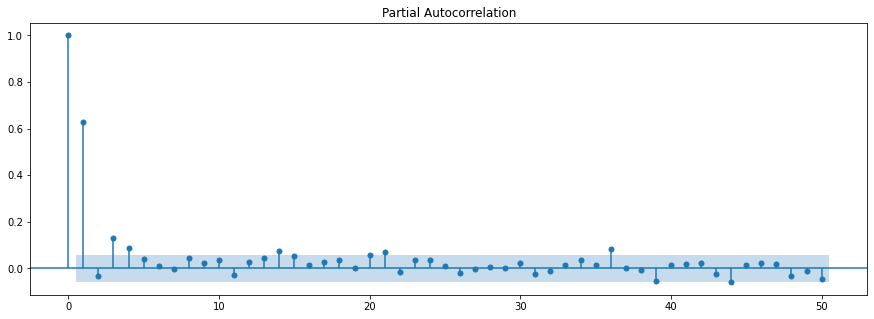

In [20]:
plt.figure(); tsaplots.plot_acf(eolica_porcentual, lags=50); plt.show()
plt.figure(); tsaplots.plot_pacf(eolica_porcentual, lags=50); plt.show()

Vemos cómo decrece rápido tras unos pocos puntos, lo que nos confirma que es estacionaria. No obstante aquí también se puede apreciar que cada 7 puntos se ve como cierto máximo en la altura de estos que es otra forma más de ver esa componente estacional pequeña que tenemos.

Podemos incluso terminar de matar esa pequeña componente mediante la diferenciación con un lag de 7 puntos.

#### Diferenciando la serie temporal

<Figure size 1080x360 with 0 Axes>

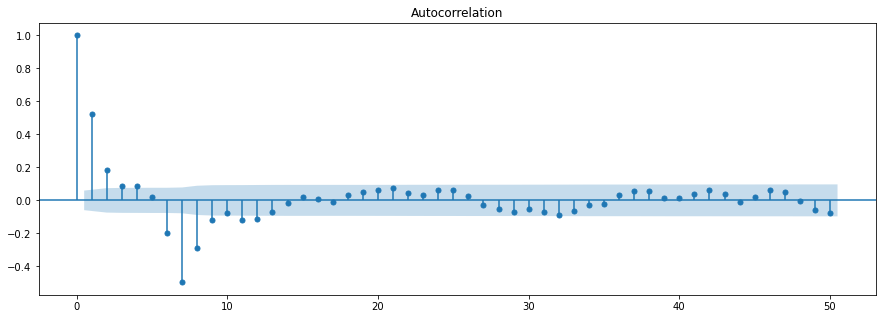

<Figure size 1080x360 with 0 Axes>

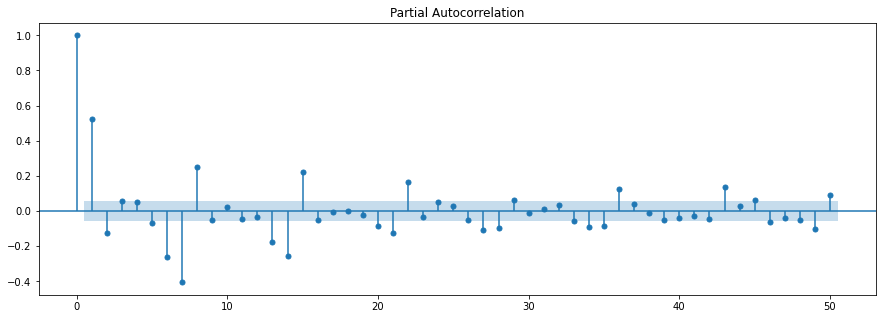

In [21]:
lag = 7
series_diff_est=eolica_porcentual.diff(lag)
series_stacionary=series_diff_est[lag:-1]

plt.figure(); tsaplots.plot_acf(series_stacionary, lags=50); plt.show()
plt.figure(); tsaplots.plot_pacf(series_stacionary, lags=50); plt.show()

Las correlaciones mueren aún más rápido tras la diferenciación, cosa que nos interesa.

In [22]:
kpsstest = kpss(series_stacionary, nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic            0.041779
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [23]:
dftest = adfuller(series_stacionary)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                         'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                -9.649373e+00
p-value                        1.448555e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.066000e+03
Critical Value (1%)           -3.436499e+00
Critical Value (5%)           -2.864255e+00
Critical Value (10%)          -2.568216e+00
dtype: float64


Los tests nos dicen que la serie es "más estacionaria" aún.

Tras este análisis ya hemos visto bastante en detalle la serie temporal que tenemos delante. Podemos usar la serie original o la diferenciada si queremos la máxima rigurosidad, pero a efectos prácticos debería ser lo mismo.

## Predicción

### Creación de conjuntos

Lo primero es la separación en los conjuntos de entrenamiento, test y validación de acuerdo con el enunciado.

In [24]:
s_tr = eolica_porcentual['2016']
s_va = eolica_porcentual['2017']
s_te = eolica_porcentual['2018']

n_tr = len(s_tr)
n_va = len(s_va)
n_te = len(s_te)

n_tr, n_va, n_te

(366, 365, 365)

Veamos las estadísticas de cada conjunto. Deben ser parecidas si queremos que tenga sentido nuestro análisis:

In [25]:
s_tr.describe()

count    366.000000
mean       0.161007
std        0.170666
min        0.000339
25%        0.034269
50%        0.101451
75%        0.236508
max        0.841489
Name: WindEnergy, dtype: float64

In [26]:
s_va.describe()

count    365.000000
mean       0.151004
std        0.153885
min        0.000002
25%        0.034173
50%        0.096975
75%        0.224841
max        0.734208
Name: WindEnergy, dtype: float64

In [27]:
s_te.describe()

count    365.000000
mean       0.177727
std        0.176569
min        0.000000
25%        0.037059
50%        0.119212
75%        0.252990
max        0.821950
Name: WindEnergy, dtype: float64

Vemos que todos los valores estadísticos para los 3 conjuntos son similares, podemos continuar con nuestro ejercicio de predicción.

### Modelos clásicos de predicción

Pasamos a utilizar los modelos clásicos de predicción en series temporales. Para ello utilizamos la clase SARIMAX, a la que, según los hiperparámetros entregados actuará como un modelo u otro.

Cargamos además todas las funciones que vimos en clase para tenerlas ya, modificando donde sea necesario para adaptarlas a nuestro problema.

#### Definición de funciones

In [28]:
def SARIMAX_train(s, order, n_tr, period=0, seasonal_order=(0,0,0,0), exog=None):
    s_aux = s.copy()
    if (period != 0):
        s_aux = s_aux.diff(periods=period)
    
    if exog is None:
        exogTrain = None
    else:
        exogTrain = exog[:n_tr].to_numpy()
        
    tr_mod = sm.tsa.SARIMAX(s_aux[:n_tr].to_numpy(), exog=exogTrain, 
                            order=order, seasonal_order=seasonal_order)
    #The parameter values are estimated using just the training data
    tr_res = tr_mod.fit()

    #Extend the parameters to the whole series
    if exog is None:
        exogExtend = None
    else:
        exogExtend = exog.to_numpy()
        
    res = tr_res.extend(s_aux.to_numpy(), exog=exogExtend)
    
    return res

In [29]:
def SARIMAX_predict(model, s, start, end, horizon=0, period=0):
    if horizon == 0:
        pred = model.predict(start=start, end=end - 1, dynamic=False)
    else:
        pred = []
        for i in range(start, end):
            print('\r\tComputing... (%5d / %5d)' % (i, end), end='')
            pred.append(model.predict(start=i-horizon, end=i, dynamic=True)[horizon])
        pred = np.array(pred)
        print('\r%50s\r' % ' ', end='')
    if (period != 0):
        return pred + s[start - period:end - period].to_numpy()
    else:
        return pred

In [30]:
def errors_by_day(true, pred, MAE=True):
    ind = true.index
    ind_day = ind.day
    min_day = ind_day.min()
    max_day = ind_day.max()
    
    if MAE==True:
        maes = [mean_absolute_error(true, pred)]
        for day in range(min_day, max_day + 1):
            maes.append(mean_absolute_error(true[ind_day == day].to_numpy(), 
                                            pred[ind_day == day]))
        return np.arange(min_day, max_day + 1), maes
    else: 
        mses = [mean_squared_error(true, pred)]
        for day in range(min_day, max_day + 1):
            mses.append(mean_squared_error(true[ind_day == day].to_numpy(), 
                                           pred[ind_day == day]))
        return np.arange(min_day, max_day + 1), mses

In [31]:
def validate(horizon, s, n_tr, n_va, period=0):
    vec_p = np.arange(10)
    vec_q = np.arange(10)
    
    best_e = np.inf
    
    true = s[n_tr:n_tr + n_va].to_numpy()
    for p in vec_p:
        for q in vec_q:
            try:
                model = SARIMAX_train(s, (p, 0, q), n_tr, period=period)
                pred = SARIMAX_predict(model, s, n_tr, n_tr + n_va, horizon, period=period)
                e = mean_absolute_error(true, pred)
            except Exception as exc:
                e = np.inf
            if (e < best_e):
                best_e = e
                best_p = p
                best_q = q
            
            print('%d %d => %.4f' % (p, q, e))
    
    order = (best_p, 0, best_q)
    print('\tBest:', order)

    return order

In [32]:
def validate_seasonal(horizon, s, n_tr, n_va, p, d, q, per):
    vec_P = np.arange(3)
    vec_Q = np.arange(2)
    vec_D = np.arange(8)
    
    best_P = 50
    best_Q = 50
    best_D = 50
    best_e = np.inf
    
    true = s[n_tr:n_tr + n_va].to_numpy()
    for P in vec_P:
        for Q in vec_Q:
            for D in vec_D:
                try:
                    print("TRAIN %d %d % d" % (P, D, Q))
                    model = SARIMAX_train(s, (p, d, q), n_tr, period=0, seasonal_order=(P,D,Q,per))
                    print("PRED")
                    pred = SARIMAX_predict(model, s, n_tr, n_tr + n_va, horizon, period=0)
                    e = mean_absolute_error(true, pred)
                except Exception as exc:
                    e = np.inf
                if (e < best_e):
                    best_e = e
                    best_P = P
                    best_Q = Q
                    best_D = D
            
                print('%d %d % d => %.4f' % (P, D, Q, e))
    
    seasonal_order = (best_P, best_D, best_Q, per)
    print('\tBest:', seasonal_order)

    return seasonal_order

#### AR,AM o ARMA

Primero pasamos a la elección entre modelos sencillos como ***AR***,***AM*** o ***ARMA***. Para ellos recuperamos los gráficos de autocorrelaciones que nos pueden dar pistas de ello.

Recordemos que estos modelos se utilizan en ***series estacionarias*** y que nosotros tenemos una componente estacional. Pero por lo pequeña que es merece la pena comprobar antes estos modelos.

<Figure size 1080x360 with 0 Axes>

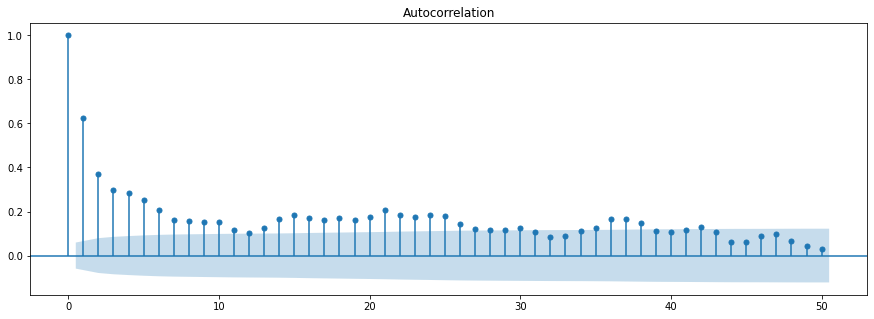

<Figure size 1080x360 with 0 Axes>

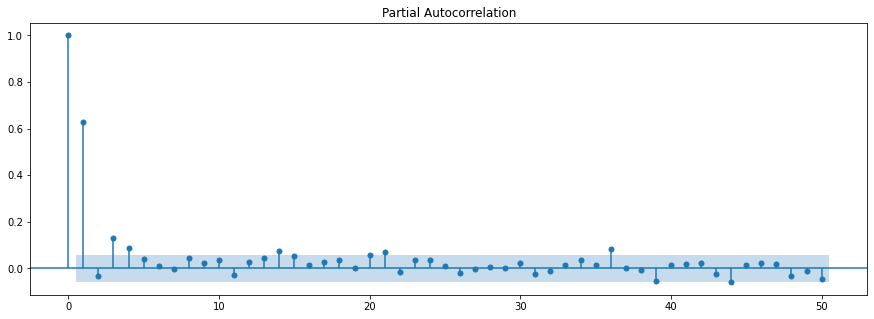

In [33]:
plt.figure(); tsaplots.plot_acf(eolica_porcentual, lags=50); plt.show()
plt.figure(); tsaplots.plot_pacf(eolica_porcentual, lags=50); plt.show()

En el ACF tenemos una caida exponencial rápida y luego comportamiento sinusoidal. En el PACF tenemos el primer p significativo y luego una caída brusca a 0. Ambos comportamientos nos llevan a pensar en un modelo AR para la serie, con p = 1, que será lo primero que utilicemos.

In [34]:
p = 1
q = 0

In [35]:
periodo=7
mod = SARIMAX_train(eolica_porcentual, (p, 0, q), n_tr+n_va, period=periodo)
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1096
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 304.055
Date:                Fri, 07 Jan 2022   AIC                           -604.111
Time:                        23:01:21   BIC                           -594.112
Sample:                             0   HQIC                          -600.328
                               - 1096                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5530      0.028     19.973      0.000       0.499       0.607
sigma2         0.0309      0.001     24.213      0.000       0.028       0.033
Ljung-Box (L1) (Q):                   1.93   Jarque-

Como ya vimos en clase, una buena comporbación es ver el comportamiento de los residuos para comprobar que son independientes y gaussianos.

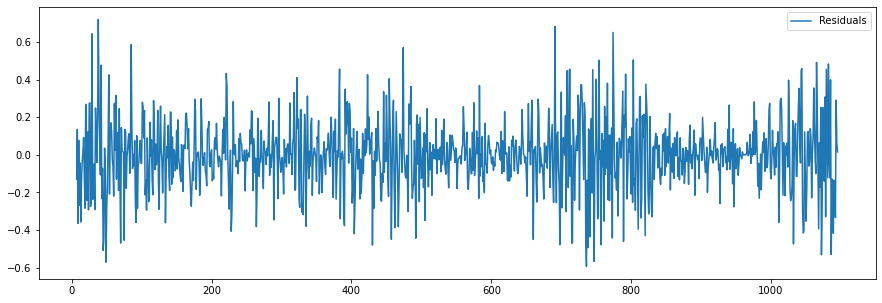

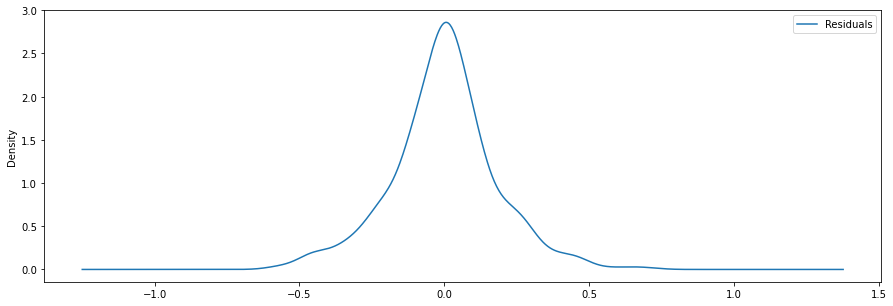

In [36]:
residuals = pd.DataFrame(mod.resid, columns=['Residuals'])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()

In [37]:
residuals.describe()

,Residuals
count,1089.000000
mean,-0.001433
std,0.182806
min,-0.593217
25%,-0.099774
50%,0.002296
75%,0.091937
max,0.720477


Los residuos parecen algo aleatorios pero de una magnitud importante en algunos lados. Si nos fijamos en la densidad vemos un comportamiento que parece una normal pero algo ancha y abultada en las colas.

Viendo las estadísticadas vemos que la media es cercana a cero pero la desviación estándar es 0.18, algo mejorable.

Recordando que el comportamiento ideal sería una delta de Dirac en el 0 nos podemos dar cuenta de que el modelo, aunque parece ser decente, es como ya hemos dicho, mejorable.

Pasamos a la ***predicción*** a distintos horizontes:

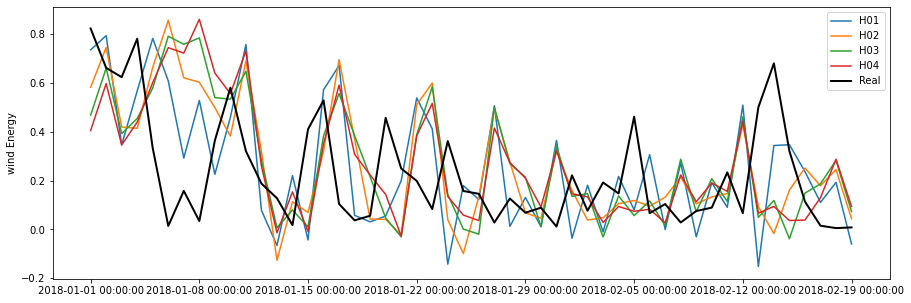

In [38]:
n_horizon=4
periodo=7

start=n_tr + n_va
end=n_tr + n_va + n_te

for h in range(n_horizon):
    file = '%s/pred0_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica_porcentual, start, end, h, 
                               period=periodo)
        np.save(file, pred)
    plt.plot(pred[:50], label='H%02d' % (h + 1))
    

y = eolica_porcentual[start:start+50]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=periodo)
plt.xticks(xticks, x[xticks])
plt.ylabel("wind Energy")
plt.legend()
plt.show()

El modelo no es muy acertado y el único que parece si quiera comportarse de manera similar el del horizonte 1, hay bastante que mejorar. Para tener una cifra que nos sirva para comparar modelos vamos a pasar a la ***evaluación*** del error cuadrático medio.

MAE Total H01: 0.14
MAE Total H02: 0.16
MAE Total H03: 0.16
MAE Total H04: 0.16


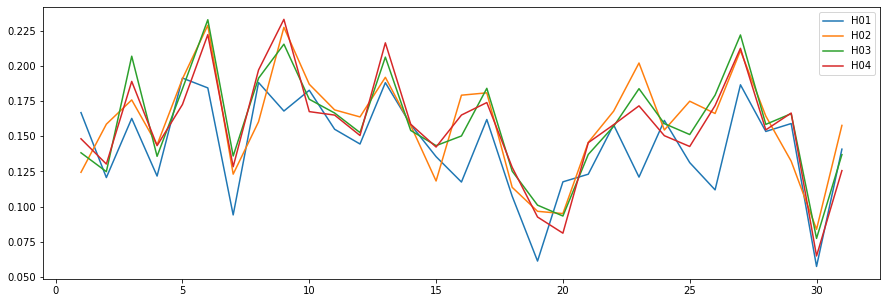

In [39]:
maes_h=[]
n_horizon=4
for h in range(n_horizon):
    file = '%s/pred0_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    hours, maes = errors_by_day(eolica_porcentual[start:end], pred, MAE=True)
    maes_h.append(maes)
    
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(hours, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

Tenemos un error en torno al 15%, algo bastante grande que debemos mejorar. Como era de esperar, el error para horizonte 1 es menor que los demás. Vayamos a la búsqueda de hiperparámetros mediante ***backtesting***. Para no tener tanta carga computacional, vamos a limitarnos a calcular para el horizonte 0.

In [40]:
file = '%s/order.npy' % (output_folder)
if isfile(file):
    order = np.load(file)
    print(order)
else:
    order = validate(0, eolica_porcentual, n_tr, n_va - 6, period=periodo)
    np.save(file, order)

[2 0 7]


Sorprendentemente el mejor modelo es un ***ARMA(2,7)***. Coge 7 retrasos en los ruidos siendo 7 la estacionalidad que hay.

Veamos la predicción con este modelo.

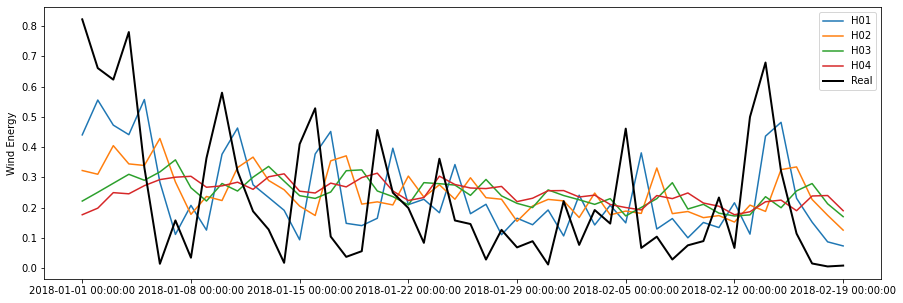

In [41]:
maes_h = []
n_horizon=4
periodo=7

start=n_tr + n_va
end=n_tr + n_va + n_te

mod = SARIMAX_train(eolica_porcentual, order, n_tr + n_va, period=periodo)

for h in range(n_horizon):
    file = '%s/predARMA_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica_porcentual, start, end, h, 
                               period=periodo)
        np.save(file, pred)
    plt.plot(pred[:50], label='H%02d' % (h + 1))
    days, maes = errors_by_day(eolica_porcentual[start:end], pred, MAE=True)
    maes_h.append(maes)
    

y = eolica_porcentual[start:start+50]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=periodo)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

El modelo de un horizonte para comportarse esta vez bastante parecido a los datos originales siempre como un paso por detrás aunque aún es algo diferente a lo real. El del horizonte dos es medianamente salvable pero los siguientes horizontes ya no sirven mucho.

MAE Total H01: 0.10
MAE Total H02: 0.12
MAE Total H03: 0.13
MAE Total H04: 0.13


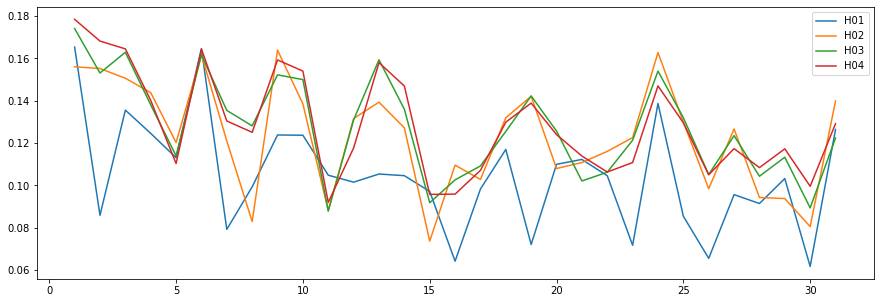

In [42]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(days, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

Hemos conseguido bajar del rango 14%-16% al rango 10%-13% gracias al modelo ***ARMA(2,7)***, algo mejor pero sigue siendo mejorable, veamos con modelos más complejos.

#### ARIMA

Probamos ***ARIMA*** con diferenciación de grado 1 para ver si hay alguna mejora, aunque no debería ya que este se encarga de modelar las tendencias, cosa que vimos que no tenía durante el análisis. No obstante probemos a ver qué ocurre.

In [43]:
periodo=7
p=2
d=1
q=7
mod = SARIMAX_train(eolica_porcentual,(p, d, q), n_tr+n_va, period=periodo)
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1096
Model:               SARIMAX(2, 1, 7)   Log Likelihood                 580.200
Date:                Fri, 07 Jan 2022   AIC                          -1140.400
Time:                        23:01:25   BIC                          -1090.414
Sample:                             0   HQIC                         -1121.486
                               - 1096                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      0.033     -6.552      0.000      -0.283      -0.152
ar.L2         -0.3054      0.031     -9.828      0.000      -0.366      -0.244
ma.L1          0.0276      0.316      0.087      0.9

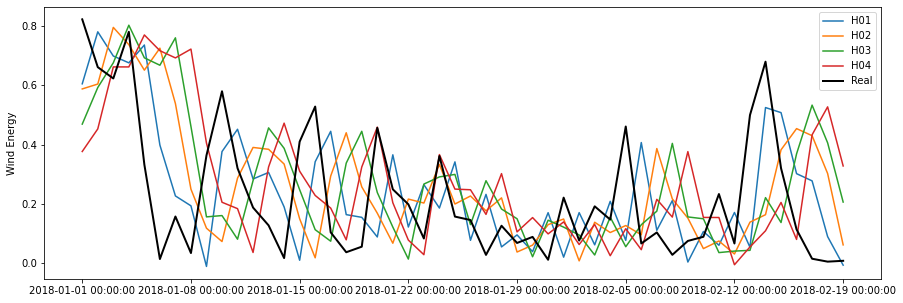

In [44]:
maes_h = []
n_horizon=4
periodo=7

start=n_tr + n_va
end=n_tr + n_va + n_te

for h in range(n_horizon):
    file = '%s/predARIMA_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica_porcentual, start, end, h, 
                               period=periodo)
        np.save(file, pred)
    plt.plot(pred[:50], label='H%02d' % (h + 1))
    days, maes = errors_by_day(eolica_porcentual[start:end], pred, MAE=True)
    maes_h.append(maes)
    

y = eolica_porcentual[start:start+50]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=periodo)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

MAE Total H01: 0.12
MAE Total H02: 0.14
MAE Total H03: 0.14
MAE Total H04: 0.14


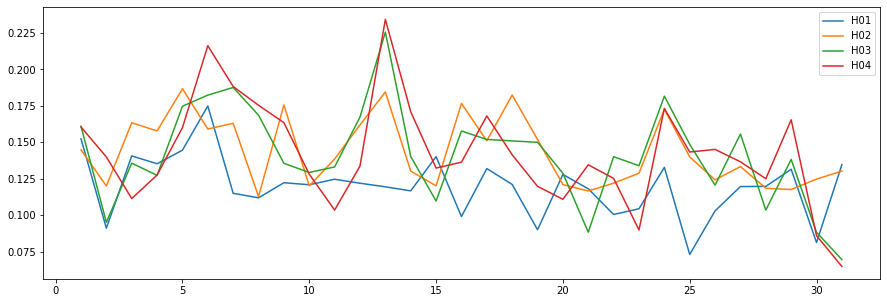

In [45]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(days, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

El modelo no solo no ha mejorado si no que ha empeorado un poco. Lo ideal sería pasar por una fase de validación calculando hiperparámetros pero sabiendo que ARIMA es añadir una preocupación en tendencias, cosas que nuestra serie no tenía, vamos a dejarlo por aquí.

#### SARIMA

Pasamos a ***SARIMA***, en la que tenemos que evaluar la parte estacional. Para ello utilizamos validate stational de clase. Usamos los hiperparámetros anteriores con mejores valores:

In [46]:
p=2
d=0
q=7

per=7

In [47]:
file = '%s/sarima_order.npy' % (output_folder)
if isfile(file):
    seasonal_order = np.load(file)
    print(seasonal_order)
else:
    seasonal_order = validate_seasonal(0, eolica_porcentual, n_tr, n_va - 6, p, d, q, per)
    np.save(file, seasonal_order)

[1 0 0 7]


Ahora entrenamos el modelo entero con el valor anterior. ***IMPORTANTE*** recordar que ahora debemos poner que el periodo es 0 ya que ya viene modelado en el seasonal order.

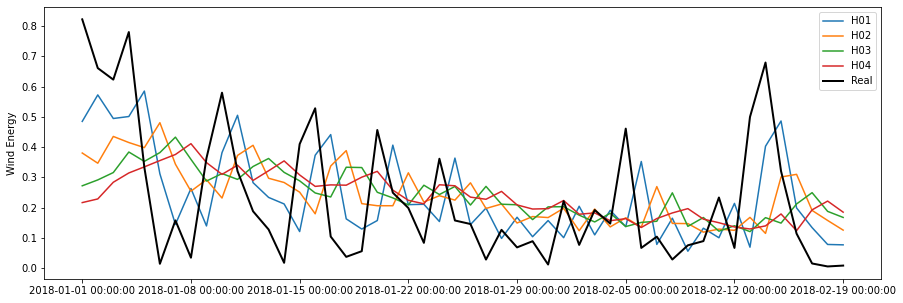

In [48]:
maes_h = []
n_horizon=4

start=n_tr + n_va
end=n_tr + n_va + n_te

mod = SARIMAX_train(eolica_porcentual, (p, d, q), n_tr + n_va, period=0, seasonal_order=seasonal_order)

for h in range(n_horizon):
    file = '%s/predSARIMA_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica_porcentual, start, end, h, period=0)
        np.save(file, pred)
    plt.plot(pred[:50], label='H%02d' % (h + 1))
    days, maes = errors_by_day(eolica_porcentual[start:end], pred, MAE=True)
    maes_h.append(maes)
    

y = eolica_porcentual[start:start+50]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=7)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

MAE Total H01: 0.10
MAE Total H02: 0.12
MAE Total H03: 0.12
MAE Total H04: 0.12


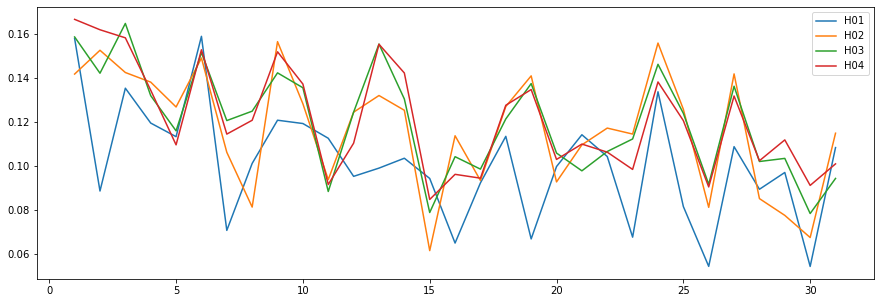

In [49]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(days, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

A pesar de utilizar el modelo ***SARIMA*** no hemos conseguido una mejora significativa la predicción. Para horizonte 0 se ha quedado igual, pero para los siguientes horizontes ha habido una mejora de un 1% así algo ha merecido la pena.

#### SARIMAX

En nuestra fuente de datos tenemos más información a parte de la energía producida. Tenemos la magnitud y dirección del viento.

Estas variables resultan de interés así que deberíamos probar a añadirlas a nuestro modelo.

Volvemos a cargar los datos, ahora utilizando todas las columnas.

In [50]:
eolica = pd.read_csv('Eolica.csv',
                    header=0, parse_dates=[0], index_col=[0], usecols=[0, 1, 2, 3], 
                    dayfirst=True, squeeze=True)

In [51]:
eolica.head(10)

,WindSpeed,WindDirection,WindEnergy
Date,,,
2016-01-01,12.96,190.0,280606.59
2016-01-02,10.68,217.0,181981.12
2016-01-03,16.69,223.0,329470.87
2016-01-04,11.35,250.0,216707.38
2016-01-05,12.72,261.0,204859.99
2016-01-06,14.62,222.0,278101.80
2016-01-07,16.03,233.0,247007.30
2016-01-08,NaN,NaN,NaN
2016-01-09,NaN,NaN,NaN


No podemos olvidarnos de los missing values y del paso de energía porcentual.

In [52]:
eolica.interpolate(method='linear',axis=0, inplace=True)

In [53]:
eolica['WindEnergy'] = eolica['WindEnergy']/17560/24

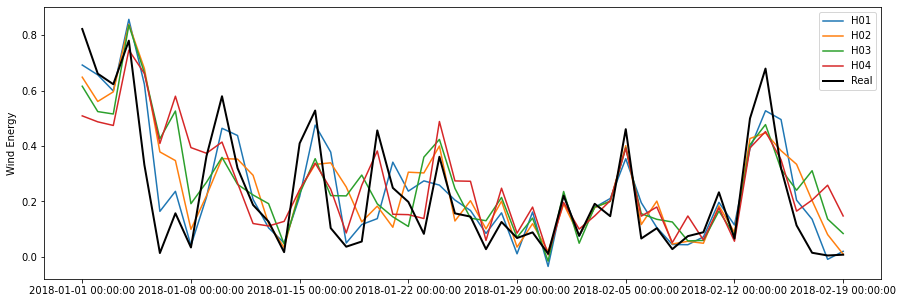

In [54]:
maes_h = []
n_horizon=4

start=n_tr + n_va
end=n_tr + n_va + n_te

mod = SARIMAX_train(eolica_porcentual, (p, d, q), n_tr + n_va, period=0, seasonal_order=seasonal_order,
                    exog=eolica.loc[:,['WindSpeed','WindDirection']])

for h in range(n_horizon):
    file = '%s/predSARIMAX_H%02d.npy' % (output_folder, h)
    if isfile(file):
        pred = np.load(file)
    else:
        pred = SARIMAX_predict(mod, eolica_porcentual, start, end, h, period=0)
        np.save(file, pred)
    plt.plot(pred[:50], label='H%02d' % (h + 1))
    days, maes = errors_by_day(eolica_porcentual[start:end], pred, MAE=True)
    maes_h.append(maes)
    

y = eolica_porcentual[start:start+50]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=7)
plt.xticks(xticks, x[xticks])
plt.ylabel("Wind Energy")
plt.legend()
plt.show()

MAE Total H01: 0.05
MAE Total H02: 0.06
MAE Total H03: 0.06
MAE Total H04: 0.07


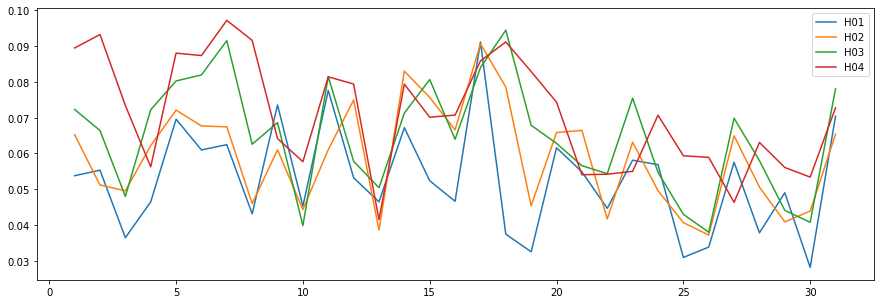

In [55]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    plt.plot(days, maes[h, :], label='H%02d' % (h + 1))
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))
plt.legend()
plt.show()

Añadir la variable exógena de la fuera del viento ha supuesto una gran mejora. El error absoluto medio ha pasado al 5%-7%, lo que supone la mitad que antes.

Ahora sí que estamos ante un modelo aceptable. Lo más destacable es que la predicción para un horizonte 4 ahora es mejor que la predicción de antes para horizonte 1. Además, simplemente nos ha supuesto añadir una variable por la que ni hemos tenido que preocuparnos más que de rellenar los missing values y nada más. Solo con añadirla como parámetro tenemos tal mejora.

Se ha probado a añadir las dos variables (magnitud y dirección) pero el resultado no ha sido mejor así que lo dejamos aquí por el lado de las variables exógenas.

Como este es, aparentemente, el mejor modelo que tenemos, vamos a anlizar los resiudos que nos deja:

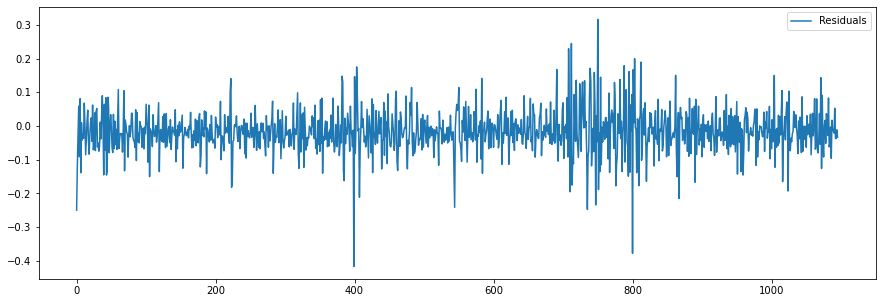

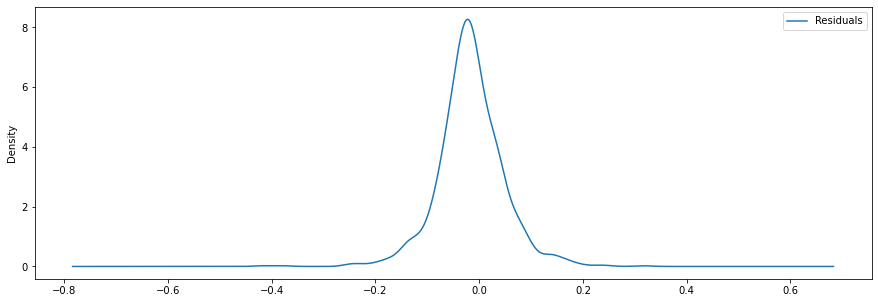

In [56]:
residuals = pd.DataFrame(mod.resid, columns=['Residuals'])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()

De la primera gráfica podemos ver que son aún más azarosos que en el primer caso, lo que es bueno. Además de que son menores en magnitud como habíamos visto con las gráficas anteriores.

Si nos fijamos en las distribución de densidad de probabilidad vemos que se ha estrechado bastante más en torno a cero. En la primera gráfica los comienzos de las colas estaban en torno a -0.5 y 0.5 mientras que aquí están en -0.2 y 0.2, mucho más parecido a una delta de Dirac.

### Redes Neuronales

Podemos probar con el cambio de paradigma y utilizar redes neuronales solo para hacernos una idea de cómo sería. Utilizando la red sencilla basada en LSTM que vimos en clase veamos si obtenemos unos resultados decentes.

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [58]:
rnn = Sequential()
rnn.add(LSTM(200,batch_input_shape=(1, 1, 1), stateful=True))
rnn.add(Dropout(0.4, input_shape=(1,)))
rnn.add(Dense(1)) # Imporante que sea 1 ya que estamos en regresión.
rnn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

In [59]:
def x_y_sets(s, h=0):
    y = s[h+1:]
    x = s[:-(h+1)]
    
    x = MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))
    
    x, y = x.reshape(-1, 1, 1), y.to_numpy().reshape(-1, 1)
    return x, y

In [60]:
eolica = pd.read_csv('eolica.csv',
                    header=0, parse_dates=[0], index_col=[0], usecols=[0, 3], dayfirst=True, 
                    squeeze=True)

eolica.interpolate(method='linear',axis=0, inplace=True)

eolica_porcentual = eolica/17560/24

In [61]:
s_tr = eolica_porcentual['2016']
s_va = eolica_porcentual['2017']
s_te = eolica_porcentual['2018']

n_tr = len(s_tr)
n_va = len(s_va)
n_te = len(s_te)

n_tr, n_va, n_te

(366, 365, 365)

Calculamos solo unos pocos horizontes para aumentar tanto la carga computacional.

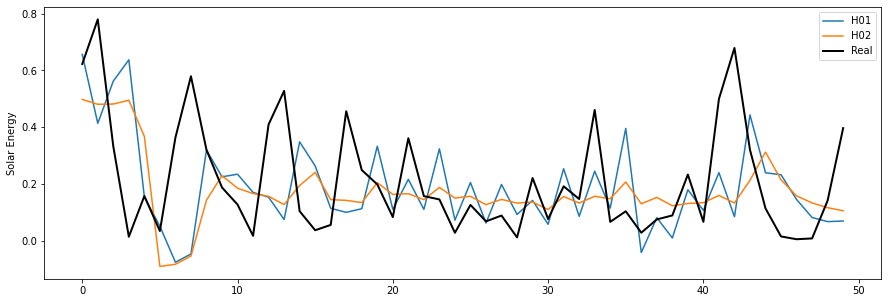

In [62]:
mae_lstm=[]
for h in range(2):
    x, y = x_y_sets(eolica_porcentual, h)
    x_train, x_test = x[:n_tr+n_va], x[n_tr+n_va:]
    y_train, y_test = y[:n_tr+n_va], y[n_tr+n_va:]

    file = '%s/LSTM/predLSTM_H%02d.npy' % (output_folder, h)
    if isfile(file):
        preds_rnn = np.load(file)
    else:
        history_rnn = rnn.fit(x_train, y_train, epochs=150, batch_size=1, shuffle=False)
        
        rnn.reset_states()
        rnn.predict(x_train, batch_size=1)
        preds_rnn = rnn.predict(x_test, batch_size=1)
    
        np.save(file, preds_rnn)
        
    plt.plot(preds_rnn[:50], label='H%02d' % (h+1))
    mae_lstm.append(mean_absolute_error(y_test, preds_rnn))

y_plot = y_test[:50]
plt.plot(y_plot, 'k', linewidth=2, label='Real')
plt.ylabel("Solar Energy")
plt.legend()
plt.show()

MAE Total H01: 0.11
MAE Total H02: 0.12


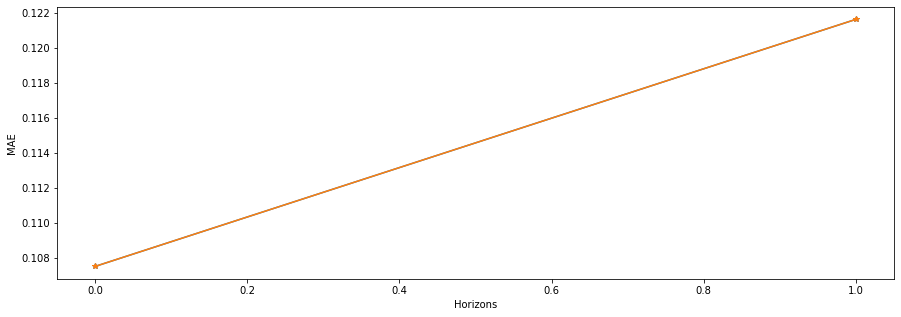

In [63]:
for h in range(2):
    plt.plot(mae_lstm, '*-')
    print('MAE Total H%02d: %.2f' % (h + 1, mae_lstm[h]))
plt.xlabel("Horizons")
plt.ylabel("MAE")
plt.show()

La presentación del error medio es diferente ahora pero los valores los tenemos y son 0.11 y 0.12 para los horizontes 1 y 2 respectivamente. Estos valores son del orden del modelo SARIMA, es decir, del orden de nuestro segundo mejor modelo. Para lo simple que es la red, sin habernos preocupado por variar parámetros y/o añadir capas, el resultado es decente. Quizás si profundizáramos más conseguiríamos unos resultados mejores que con SARIMAX pero realmente el espacio de mejora no es muy grande (considerando que no nos estamos jugando el sueldo en esto).

Como resumen:

- Hemos topado con una serie temporal sobre la producción energética de un parque eólico durante 3 años. 

- Tras tratar los valores que faltaban la hemos visualizado. A priori me había parecido ver un comportamiento estacional anual.

- Tras los diferentes tests ADF y KPSS además de las autocorrelaciones quedó demostrado que no.

- Se vio que había una ligera componente estacional pequeña de periodo una semana.

- Se procedió con modelos sencillos AR, MA y ARIMA y se obtuvieron los valores (p,d,q) de (2,0,7). Nos dieron un modelo algo pobre.

- Por ello pasamos a modelos más complicados, el que más sentido tenía era SARIMA debido a esa mínima componente estacional. Aunque por su tamaño tampoco supone una mejora tan significativa.

- Lo que vino a salvarnos el día fueron las variables exógenas, más concretamente la magnitud del viendo. Gracias a esto (SARIMAX) conseguimos reducir el error a la mitad y obtener un modelo con solo un 5% de MAE para el horizonte 1.

- Finalmente pasamos a probar mínimamente las redes neuronales LSTM y nos dieron resultados prometedores pero peores que SARIMAX. Como ya se ha dicho antes, es posible que dieran un modelo mejor que lo que tenemos pero el espacio de mejora tampoco es muy grande.